<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    System 2 - Homework 3<br>
<font color=2565AE size=5>
    Spring 2025<br>
<font color=3C99D size=5>
    Graph RAG <br>

*`Full Name:`* ...

*`SID:`* ...


----




In this Notebook, we'll explore the implementation of the GraphRAG (Graph-based Retrieval-Augmented Generation) approach to query-focused summarization, as described in the research paper `"From Local to Global: A GraphRAG Approach to Query-Focused Summarization"` by Darren Edge et al. This method is designed to generate comprehensive and diverse answers to global questions over entire text corpora by leveraging a graph-based text index and an LLM (Large Language Model).

We'll walk through a Python-based implementation that includes key steps from the paper, demonstrating how to process documents, build a graph, detect communities, and generate a final answer to a query.

Overview of the proposed Pipeline:
![GraphRAG](https://drive.google.com/uc?export=view&id=16Pv1vt_yY6u9ARodmnkbRmQttcpnjB18)

In [1]:
!pip install -q networkx leidenalg cdlib python-igraph pypdf

In [2]:
%%capture --no-stderr
!pip install langchain-opentutorial

In [3]:
from langchain_opentutorial import package

package.install(
    [
        "langchain_core",
        "langchain_community",
        "langchain-graphrag",

    ],
    verbose=False,
    upgrade=False,
)

In [ ]:
# Download and save sample PDF file to ./data directory
import requests
import os

def download_pdf(url, save_path):
    """
    Downloads a PDF file from the given URL and saves it to the specified path.

    Args:
        url (str): The URL of the PDF file to download.
        save_path (str): The full path (including file name) where the file will be saved.
    """
    try:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # Download the file
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error for bad status codes

        # Save the file to the specified path
        with open(save_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

        print(f"PDF downloaded and saved to: {save_path}")
    except Exception as e:
        print(f"An error occurred while downloading the file: {e}")

# Configuration for the PDF file
pdf_url = "https://arxiv.org/pdf/2404.16130v1"
file_path = "./data/2404.16130v1.pdf"

# Download the PDF
download_pdf(pdf_url, file_path)

# Load the GraphRAG paper using PyPDFLoader.
# PyPDFLoader loads PDF content on a per-page basis.
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
docs = loader.load()
print(f"Loaded {len(docs)} documents.")
print(docs[0].page_content)

In [8]:
from langchain_core.documents import Document
from langchain_graphrag.indexing import TextUnitExtractor
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=100)
text_unit_extractor = TextUnitExtractor(text_splitter=splitter)

# This runs the text splitting logic on the loaded PDF pages
df_text_units = text_unit_extractor.run(docs)
df_text_units

Extracting text units ...: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 96791.63it/s]

Extracting text units ...: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 94254.02it/s]

Extracting text units ...: 100%|███████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21229.30it/s]

Extracting text units ...: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 30790.16it/s]

Extracting text units ...: 100%|██████████████████████████████████████████████████████| 7/7 [00:00<00:00, 112923.57it/s]

Extracting text units ...: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 30393.51it/s]

Extracting text units ...: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 175575.52it/s]

Extracting text units ...: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 21732.15it/s]

Extracting text units ..

document_id  \
0    a2f33f43-a09b-46b5-986b-5998e1284077   
1    a2f33f43-a09b-46b5-986b-5998e1284077   
2    a2f33f43-a09b-46b5-986b-5998e1284077   
3    a2f33f43-a09b-46b5-986b-5998e1284077   
4    a2f33f43-a09b-46b5-986b-5998e1284077   
..                                    ...   
110  af7d108f-4f3b-4fdf-902c-23e87532e2b8   
111  af7d108f-4f3b-4fdf-902c-23e87532e2b8   
112  af7d108f-4f3b-4fdf-902c-23e87532e2b8   
113  59311bb3-d662-4f0a-a57d-2da033aa2a3a   
114  59311bb3-d662-4f0a-a57d-2da033aa2a3a   

                                       id  \
0    a25c4940-1381-45ec-9fcc-46010ed27bfd   
1    d7ff043a-6c27-42bf-bd61-5750a9b0fb45   
2    ca1b02b8-547e-4c04-97ec-2c912afc7298   
3    4bde4aa4-a376-4355-a165-bfdc4d5939bd   
4    1f785446-a9af-48fd-a433-dbd2e26c6263   
..                                    ...   
110  d94bd230-254c-4f27-a9c7-1fb730a38e5b   
111  d5fb9bc5-8b21-4e63-a2f2-9d63f1ed76dd   
112  084fcb2f-21a3-4521-b513-dcf016d44025   
113  6f94d997-1ce7-4454-87b5-6a283da67c3f   
114  a83e0a8d-7dfe-44bd-9a9b-f347fcc396fc   

                                             text_unit  
0    From Local to Global: A Graph RAG Approach to\...  
1    tion from an external knowledge source enables...  
2    RAG systems. To combine the strengths of these...  
3    question, each community summary is used to ge...  
4    approaches is forthcoming at https://aka.ms/gr...  
..                                                 ...  
110  well-connected communities. Scientific Reports...  
111  a good nlg evaluator? a preliminary study. arX...  
112  arXiv:2106.00104.\nYang, Z., Qi, P., Zhang, S....  
113  Yao, L., Peng, J., Mao, C., and Luo, Y . (2023...  
114  E., et al. (2024). Judging llm-as-a-judge with...  

[115 rows x 3 columns]

In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import networkx as nx
from cdlib import algorithms
import os


model_name = "Qwen/Qwen3-4B"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
def get_response(prompt, content):
    messages = [
    {"role": "user", "content": content + ' Do not include any additional and irrelevant information. \t' + prompt}
]
    text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False # Switches between thinking and non-thinking modes. Default is True.
)
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=32768
    )
    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=32768
    )
    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

    response = tokenizer.decode(output_ids[0:], skip_special_tokens=True).strip("\n")
    return response

get_response('hi', '')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'bayanpy', 'graph_tool', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


tokenizer_config.json:   0%|          | 0.00/9.73k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

'hi'

`1. Text Chunks → Element Instances`

  First, we'll extract entities and relationships from each chunk of text using Qwen

In [10]:
def extract_element_Instances(chunks):
    """
      Inputs:
        chunks (list of str): List of text chunks.
      Output:
        List of extracted elements (entity-relationship data).
    """
    elements = []
    for index, chunk in enumerate(chunks):

        ############### Your Code - 5pts #############################
        content = 
        #######################################################
        entities_and_relations = get_response(chunk, content)
        elements.append(entities_and_relations)

        print(entities_and_relations)
    return elements


elements = extract_elements_Instances(df_text_units['text_unit'][:15])

Chunk index 0 of 15:
**Entities:**
- Darren Edge
- Ha Trinh
- Newman Cheng
- Joshua Bradley
- Alex Chao
- Apurva Mody
- Steven Truitt
- Jonathan Larson
- Microsoft Research
- Microsoft Strategic Missions and Technologies
- Microsoft Office of the CTO
- {daedge, trinhha, newmancheng, joshbradley, achaoo, moapurva, steventruitt, jolarso}
- @microsoft.com
- A Graph RAG Approach to Query-Focused Summarization
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- External knowledge source

**Relationships:**
- Darren Edge, Ha Trinh, Newman Cheng, Joshua Bradley, Alex Chao, Apurva Mody, Steven Truitt, and Jonathan Larson are authors of the paper.
- Darren Edge, Ha Trinh, Newman Cheng, Joshua Bradley, Alex Chao, Apurva Mody, and Steven Truitt contributed equally to this work.
- The paper is titled "From Local to Global: A Graph RAG Approach to Query-Focused Summarization."
- The paper is published by Microsoft Research, Microsoft Strategic Missions and Technologies, and Micr

`2. Element Instances → Element Summaries`

  Summarize the extracted entities and relationships into a structured format

In [11]:
def summarize_element_Instances(elements):
    """
      Summarizes entity-relationship data into a structured format.
      Inputs:
        elements (list): List of extracted entity-relationship data.
      Output:
        List of structured summaries as strings.
    """
    summaries = []
    for index, element in enumerate(elements):
        ############### Your Code - 5pts #############################
        content = 
        #######################################################
        response = get_response(element, content)

        print("Element summary:", response)
        summary = response
        summaries.append(summary)
    return summaries


summaries = summarize_element_Instances(elements)

Element index 0 of 15:
Element summary: **Entities:**
- Darren Edge
- Ha Trinh
- Newman Cheng
- Joshua Bradley
- Alex Chao
- Apurva Mody
- Steven Truitt
- Jonathan Larson
- Microsoft Research
- Microsoft Strategic Missions and Technologies
- Microsoft Office of the CTO
- {daedge, trinhha, newmancheng, joshbradley, achaoo, moapurva, steventruitt, jolarso}
- @microsoft.com
- A Graph RAG Approach to Query-Focused Summarization
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- External knowledge source

**Relationships:**
- Darren Edge -> is author of -> A Graph RAG Approach to Query-Focused Summarization
- Ha Trinh -> is author of -> A Graph RAG Approach to Query-Focused Summarization
- Newman Cheng -> is author of -> A Graph RAG Approach to Query-Focused Summarization
- Joshua Bradley -> is author of -> A Graph RAG Approach to Query-Focused Summarization
- Alex Chao -> is author of -> A Graph RAG Approach to Query-Focused Summarization
- Apurva Mody -> is author of 

`3. Element Summaries → Graph Communities`

  build a graph from the element summaries and detect communities using the $\href {https://en.wikipedia.org/wiki/Leiden_algorithm}{Leiden algorithm}$.



In [12]:
def graph_building(summaries):

    """
      Constructs a graph from entity-relationship summaries.
      Inputs:
        summaries (list of str): Structured summaries with entities and relationships.
      Output:
        A networkx.Graph where nodes are entities and edges are labeled relationships.
    """
    G = nx.Graph()
    for index, summary in enumerate(summaries):
        ############### Your Code - 30 pts#############################





        
        #######################################################
    return G

graph = graph_building(summaries)

Summary index 0 of 15:
Summary index 1 of 15:
Summary index 2 of 15:
Summary index 3 of 15:
Summary index 4 of 15:
Summary index 5 of 15:
Summary index 6 of 15:
Summary index 7 of 15:
Summary index 8 of 15:
Summary index 9 of 15:
Summary index 10 of 15:
Summary index 11 of 15:
Summary index 12 of 15:
Summary index 13 of 15:
Summary index 14 of 15:


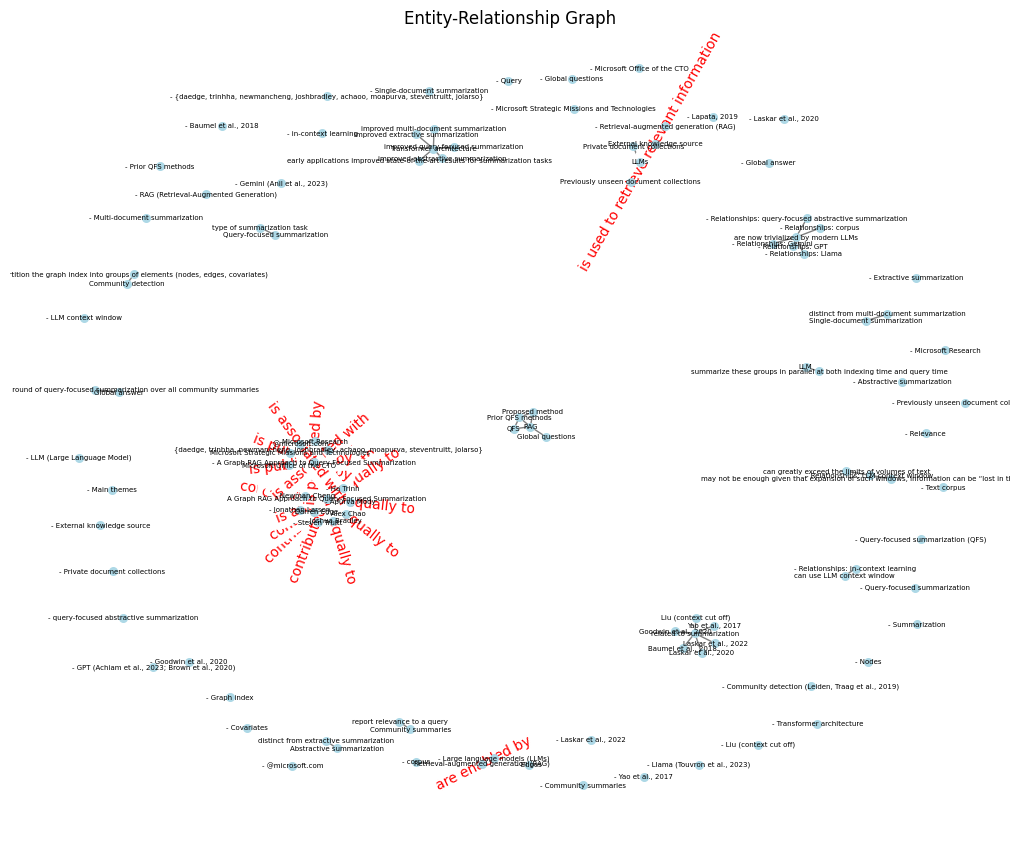

In [29]:
import matplotlib.pyplot as plt
pos = nx.spring_layout(graph)
labels = nx.get_edge_attributes(graph, 'label')

plt.figure(figsize=(10, 8))
nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=30, font_size=5, edge_color='gray')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_color='red')
plt.title("Entity-Relationship Graph")
plt.show()


In [14]:
def communities_detection(graph):
    """
      Detects communities (clusters of related entities) in the graph using the Leiden algorithm.

      Inputs:
        graph (networkx.Graph): The knowledge graph.
      Output:
        List of communities, each a list of entity names.
    """
    communities = []
    index = 0
    for component in nx.connected_components(graph):
        ############### Your Code - 30 pts #############################





        
        #######################################################
    return communities


communities = communities_detection(graph)

Component index 0 of 61:
Error processing community 0: invalid literal for int() with base 10: 'Microsoft Office of the CTO'
Component index 1 of 61:
Component index 2 of 61:
Component index 3 of 61:
Component index 4 of 61:
Component index 5 of 61:
Component index 6 of 61:
Error processing community 6: invalid literal for int() with base 10: 'Private document collections'
Component index 7 of 61:
Error processing community 7: invalid literal for int() with base 10: '- Large language models (LLMs)'
Component index 8 of 61:
Component index 9 of 61:
Component index 10 of 61:
Component index 11 of 61:
Component index 12 of 61:
Component index 13 of 61:
Component index 14 of 61:
Component index 15 of 61:
Component index 16 of 61:
Component index 17 of 61:
Component index 18 of 61:
Component index 19 of 61:
Component index 20 of 61:
Component index 21 of 61:
Component index 22 of 61:
Component index 23 of 61:
Component index 24 of 61:
Component index 25 of 61:
Component index 26 of 61:
Comp

`4. Graph Communities → Community Summaries`

  summarize each detected community.

In [15]:
def communities_summerization(communities, graph):


    """
      Creates a textual summary for each community based on its entities and their relationships.
      Inputs:
        communities (list of list): Communities detected from the graph.
        graph (networkx.Graph): The knowledge graph with edges and labels.
      Output:
        List of string summaries for each community.
    """
    community_summaries = []
    for index, community in enumerate(communities):
        ############### Your Code - 10 pts #############################



        #######################################################
    return community_summaries

community_summaries = communities_summerization(communities, graph)

Summarize Community index 0 of 46:
Summarize Community index 1 of 46:
Summarize Community index 2 of 46:
Summarize Community index 3 of 46:
Summarize Community index 4 of 46:
Summarize Community index 5 of 46:
Summarize Community index 6 of 46:
Summarize Community index 7 of 46:
Summarize Community index 8 of 46:
Summarize Community index 9 of 46:
Summarize Community index 10 of 46:
Summarize Community index 11 of 46:
Summarize Community index 12 of 46:
Summarize Community index 13 of 46:
Summarize Community index 14 of 46:
Summarize Community index 15 of 46:
Summarize Community index 16 of 46:
Summarize Community index 17 of 46:
Summarize Community index 18 of 46:
Summarize Community index 19 of 46:
Summarize Community index 20 of 46:
Summarize Community index 21 of 46:
Summarize Community index 22 of 46:
Summarize Community index 23 of 46:
Summarize Community index 24 of 46:
Summarize Community index 25 of 46:
Summarize Community index 26 of 46:
Summarize Community index 27 of 46:
Su

`6. Community Summaries → Community Answers → Global Answer`

  Finally, we generate answers from community summaries and combine them into a final global answer.

In [23]:
def generate_final_answer(community_summaries, query):

    """
      Answers a query by using each community summary, then aggregates all answers.
      Inputs:
        community_summaries (list of str): Summaries of each community.
        query (str): The user query.
      Output:
        A final answer string synthesized from all community-based answers.
    """
    intermediate_answers = []
    for index, summary in enumerate(community_summaries):
        ############### Your Code - 10 pts #############################



        

        #######################################################
    
    return final_answer

query = "What problem does Graph RAG aim to solve that traditional RAG and QFS methods cannot?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: What problem does Graph RAG aim to solve that traditional RAG and QFS methods cannot?
Summary index 0 of 46:
Intermediate answer: The summary provided does not specify the problem that Graph RAG aims to solve compared to traditional RAG and QFS methods.
Summary index 1 of 46:
Intermediate answer: The provided summary does not mention any specific problem that Graph RAG aims to solve compared to traditional RAG and QFS methods.
Summary index 2 of 46:
Intermediate answer: The provided summary does not mention any specific problem that Graph RAG aims to solve compared to traditional RAG and QFS methods.
Summary index 3 of 46:
Intermediate answer: Graph RAG aims to solve the problem of limited context understanding in traditional RAG and QFS methods by leveraging graph structures to better capture and utilize relationships between entities.
Summary index 4 of 46:
Intermediate answer: Graph RAG aims to solve the problem of information retrieval in complex, interconnected data structu

#### Analyze the proposed method for these questions. `10 pts`

- What problem does Graph RAG aim to solve that traditional RAG and QFS methods cannot?

- How does the Graph RAG architecture overcome the limitations of LLM context windows?

- What are the key steps in the Graph RAG pipeline, and how are they distributed between indexing time and query time?

- How does Graph RAG differ from previous QFS or graph-based retrieval approaches?

- What role do community detection algorithms (e.g., Leiden or Louvain) play in the Graph RAG framework?

- How does the performance of Graph RAG scale with increasing corpus size (e.g., 1M tokens)?

- What kind of summaries are generated during each stage of the Graph RAG pipeline, and how are they used?

- Why is the distinction between ‘local’ and ‘global’ queries important in the design of Graph RAG?

- How does entity extraction using GPT-4-turbo vary with chunk sizes in the HotPotQA dataset, as shown in Figure 2?

- Why do the authors claim that query-focused abstractive summarization is more appropriate than retrieval-based generation for global questions?

- In what ways does the modularity of graphs enable better summarization in the context of large corpora?

- How does Graph RAG contribute to the broader goal of sensemaking in domains like scientific discovery or intelligence analysis?